In [1]:
"""
use time to cut sequences
command 
python main_time.py --data_folder ../Data/xing/ --train_data train_item.pickle --valid_data test_item.pickle --test_data test_item.pickle --data_name xing --embedding_dim 300 --hidden_size 300 --lr 0.005
"""
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../../PyTorch_GBW_LM')
sys.path.insert(0, '../../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
                     help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
                     help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
                     help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)
parser.add_argument('--valid_start_time', default=0, type=int)
parser.add_argument('--test_start_time', default=0, type=int)
parser.add_argument('--model_name', default="samplePaddingSessionRNN", type=str)

# Get the arguments
args = parser.parse_args([])
args.cuda = torch.cuda.is_available()

In [4]:
# CUDA_VISIBLE_DEVICES=0 python eval_main_time.py --data_folder ../Data/tmall/100k_unknown_cate/ 
# --data_action item_time.pickle --data_cate cate_time.pickle --data_time time_time.pickle 
# --data_name taobao --embedding_dim 300 --hidden_size 300 --lr 0.001 --window_size 20 
# --test_observed 5 --n_epochs 100 --shared_embedding 1 --batch_size 300 
# --optimizer_type Adam --loss_type 'XE' --valid_start_time 1512172800 --test_start_time 1512259200 
# --negative_num 10000 --topk 20 --checkpoint_dir "../log/samplePaddingSessionRNN/checkpoint/01022149"


In [5]:
args.data_folder = "../../../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.embedding_dim = 256
args.hidden_size = 256
args.lr = 0.001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 100
args.shared_embedding = 1
args.batch_size = 256
args.optimizer_type = "Adam"
args.loss_type = "XE"
args.valid_start_time = 1512172800
args.test_start_time = 1512259200
args.negative_num = 10000
args.topk = 20
args.checkpoint_dir = "../../log/samplePaddingSessionRNN/checkpoint/01031151"

In [6]:
np.random.seed(args.seed)
torch.manual_seed(7)
random.seed(args.seed)

if args.cuda:
    print("gpu")
    torch.cuda.manual_seed(args.seed)
else:
    print("cpu")

gpu


In [7]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [8]:
def make_checkpoint_dir(log):
    print("PARAMETER" + "-"*10)
    now = datetime.datetime.now()
    S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
    checkpoint_dir = "../log/"+args.model_name+"/"+args.checkpoint_dir
    args.checkpoint_dir = checkpoint_dir
    save_dir = os.path.join(args.checkpoint_dir, S)

    if not os.path.exists("../log"):
        os.mkdir("../log")
    
    if not os.path.exists("../log/"+args.model_name):
        os.mkdir("../log/"+args.model_name)

    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    args.checkpoint_dir = save_dir
    
    with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
        for attr, value in sorted(args.__dict__.items()):
            msg = "{}={}".format(attr.upper(), value)
            log.addOutput2IO(msg)
            f.write("{}={}\n".format(attr.upper(), value))

    msg = "---------" + "-"*10
    log.addOutput2IO(msg)

def load_args(model_path):
    model_file = os.path.join(model_path, "model_best.pt")
    print("args file load", model_file)
    check_point = torch.load(model_file, map_location=torch.device('cpu'))
    args = check_point['args']

def load_model(network, model_path):
    print("reload model")
    model_file = os.path.join(model_path, "model_best.pt")
    print("model file", model_file)
    check_point = torch.load(model_file)

    network.load_state_dict(check_point['model'])

def count_parameters(model):
    parameter_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("parameter_num", parameter_num) 


In [9]:
model_path = args.checkpoint_dir
load_args(model_path)

BPTT = args.bptt

device = torch.device('cuda' if args.cuda else 'cpu')
print("device", device)

if args.embedding_dim == -1:
    raise AssertionError()

data_name = args.data_name

print("*"*10+"train load"+"*"*10)

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

valid_start_time = args.valid_start_time
test_start_time = args.test_start_time

st = datetime.datetime.now()
data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, args.window_size)
et = datetime.datetime.now()
print("load data duration ", et-st)

train_data = data_obj.train_dataset
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

print("+"*10+"valid load"+"+"*10)

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num

train_data_loader = MYDATALOADER(train_data, args.batch_size)
valid_data_loader = MYDATALOADER(valid_data, args.batch_size)
test_data_loader = MYDATALOADER(valid_data, args.batch_size)

ss = SampledSoftmax(output_size, negative_num, args.embedding_dim, None)

network = NETWORK(input_size, ss, args, device)
load_model(network, model_path)

### eval
loss_function = LossFunction(device, loss_type=args.loss_type)

topk = args.topk
eval = Evaluation(None, network, loss_function, device, topk, args.warm_start)

args file load ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt
device cuda
**********train load**********
action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
load data duration  0:00:08.582216
++++++++++valid load++++++++++
item num 68008
seq num 2738883
batch size 256
batch_num 10698
seq num 430797
batch size 256
batch_num 1682
seq num 430797
batch size 256
batch_num 1682


/u/sr3hd/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


reload model
model file ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt


### get time id

In [10]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [11]:
def get_timeid(time):
    time_threshold_list = [1512172800, 1512187200, 1512201600, 1512216000, 1512230400, 1512244800, 1512259200]
#     print("time threshold num", len(time_threshold_list))
    
    timeid = 0
    
    if time <= time_threshold_list[1]:
        timeid = 1
    elif time <= time_threshold_list[2]:
        timeid = 2
    elif time <= time_threshold_list[3]:
        timeid = 3
    elif time <= time_threshold_list[4]:
        timeid = 4
    elif time <= time_threshold_list[5]:
        timeid = 5
    else:
        timeid = 6
        
    return timeid

In [12]:
# time_item_freq_dict = {}
# time_bucket_recall_dict = {}
# time_bucket_mrr_dict = {}

In [13]:
def bias_eval(eval_data):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: [recall]
    time_item_recall_dict = {}
    time_item_mrr_dict = {}
    time_item_pred_dict = {} # Number of times item is predicted in each time interval

    
### t_y_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            
            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")

            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                time_i = t_y_batch[i].item()
                timeid = get_timeid(time_i)
                
                if timeid not in time_item_recall_dict:
                    time_item_recall_dict[timeid] = {}
                    time_item_mrr_dict[timeid] = {}
                if itemid_i not in time_item_recall_dict[timeid]:
                    time_item_recall_dict[timeid][itemid_i] = []
                    time_item_mrr_dict[timeid][itemid_i] = []
                
                rank = hit.nonzero()
                
                if len(rank) == 1:
                    time_item_recall_dict[timeid][itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    time_item_mrr_dict[timeid][itemid_i].append(rank.item())
                else:
                    time_item_recall_dict[timeid][itemid_i].append(0.0)
                    time_item_mrr_dict[timeid][itemid_i].append(0.0)
                
                for pred in preds[i]:
                    pred = pred.item()
                    if timeid not in time_item_pred_dict:
                        time_item_pred_dict[timeid] = {}
                    if pred not in time_item_pred_dict[timeid]:
                        time_item_pred_dict[timeid][pred] = 0.0
                    time_item_pred_dict[timeid][pred] += 1.0
                    
                
            total_test_num.append(y_action_batch.view(-1).size(0))
            
    return time_item_recall_dict, time_item_mrr_dict, time_item_pred_dict
    

In [14]:
def get_time_item_freq(eval_data, time_item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                
                if time_id not in time_item_freq_dict:
                    time_item_freq_dict[time_id] = {}
                if item_i not in time_item_freq_dict[time_id]:
                    time_item_freq_dict[time_id][item_i] = 0.0
                time_item_freq_dict[time_id][item_i] += 1.0
        
        for time in sorted(list(time_item_freq_dict.keys())):
            if time > 1:
                for item in time_item_freq_dict[time-1]:
                    if item not in time_item_freq_dict[time]:
                        time_item_freq_dict[time][item] = 0.0
                    time_item_freq_dict[time][item] += time_item_freq_dict[time-1][item]
#     return time_item_freq_dict

In [15]:
def get_item_freq(eval_data, item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                
                if item_i not in item_freq_dict:
                    item_freq_dict[item_i] = 0.0
                item_freq_dict[item_i] += 1.0

In [16]:
def load_train_freq(time_item_freq_dict, item_freq_dict):
    for time in time_item_freq_dict:
        item_freq_dict_time = time_item_freq_dict[time]
        
        for item in item_freq_dict:
            if item not in item_freq_dict_time:
                item_freq_dict_time[item] = 0.0
            item_freq_dict_time[item] += item_freq_dict[item]
    
    time_item_freq_dict[0] = {}
    for item in item_freq_dict:
        time_item_freq_dict[0][item] = item_freq_dict[item]
        

In [17]:
train_item_freq_dict = {}
#get_item_freq(train_data_loader, train_item_freq_dict)

In [18]:
time_item_freq_dict = {}
get_time_item_freq(test_data_loader, time_item_freq_dict)

shuffling


In [19]:
load_train_freq(time_item_freq_dict, train_item_freq_dict) # Create time 0 where there are no items

In [20]:
def set_bucket4item(time_item_freq_dict):
#     item_freq_dict = dict(Counter(data.m_y_action))
#     print(len(item_freq_dict))
#     freq_list = list(item_freq_dict.values())
#     print(min(freq_list), max(freq_list))
#     freq_threshold_list = [0, 20, 80, 150, 200, 250, 300, 350]
    
    ### set bucket for each item in a time period
    
    time_itemid_bucketid_dict = {}
    time_bucketid_itemidlist_dict = {}
    time_bucket_freq_dict = {}
    
    sorted_time_list = sorted(list(time_item_freq_dict.keys()))
    for time in sorted_time_list:
        print("=="*10+str(time)+"=="*10)
        if time not in time_itemid_bucketid_dict:
            time_itemid_bucketid_dict[time] = {}
        if time not in time_bucketid_itemidlist_dict:
            time_bucketid_itemidlist_dict[time] = {}
        
        bucket_freq_dict_time = set_bucket4item_time_cluster(time_item_freq_dict[time], time_itemid_bucketid_dict[time], time_bucketid_itemidlist_dict[time])
        #bucket_freq_dict_time = set_bucket4item_time(time_item_freq_dict[time], time_itemid_bucketid_dict[time], time_bucketid_itemidlist_dict[time])
        time_bucket_freq_dict[time] = bucket_freq_dict_time
                
    return time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict

In [21]:
def set_bucket4item_time(item_freq_dict_time, itemid_bucketid_dict_time, bucketid_itemidlist_dict_time):
    freq_threshold_list = [0, 20, 30, 40, 80, 120, 240, 400]
    bucket_freq_dict_time = {}
    for itemid in item_freq_dict_time:
        i = item_freq_dict_time[itemid]
        bucketid = 0
        if i <= freq_threshold_list[1]:
            bucketid = 1
        elif i <= freq_threshold_list[2]:
            bucketid = 2
        elif i <= freq_threshold_list[3]:
            bucketid = 3
        elif i <= freq_threshold_list[4]:
            bucketid = 4
        elif i <= freq_threshold_list[5]:
            bucketid = 5
        elif i <= freq_threshold_list[6]:
            bucketid = 6
        elif i <= freq_threshold_list[7]:
            bucketid = 7
        else:
            bucketid = 8
            
        itemid_bucketid_dict_time[itemid] = bucketid
        if bucketid not in bucketid_itemidlist_dict_time:
            bucketid_itemidlist_dict_time[bucketid] = []
        bucketid_itemidlist_dict_time[bucketid].append(itemid)
        
    print("bucket", len(bucketid_itemidlist_dict_time), bucketid_itemidlist_dict_time.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(1, len(bucketid_itemidlist_dict_time)+1):
        itemid_list_bucket = bucketid_itemidlist_dict_time[bucketid]
        freq_bucket = 0
        for itemid in itemid_list_bucket:
            freq_bucket += item_freq_dict_time[itemid]
        bucket_freq_dict_time[bucketid] = freq_bucket
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))
#     print("++"*20)
    return bucket_freq_dict_time

In [121]:
from sklearn.cluster import KMeans
def set_bucket4item_time_cluster(item_freq_dict_time, itemid_bucketid_dict_time, bucketid_itemidlist_dict_time):
    num_clusters = 5
    bucket_freq_dict_time = {}
    cluster_pops = {}
    popularities = np.array(list(item_freq_dict_time.values()))
    if len(popularities) > 0:
        clusters = KMeans(num_clusters)
        labels = clusters.fit_predict(popularities.reshape(-1, 1))
        centroids = clusters.cluster_centers_
        sorted_centroids = sorted(centroids)
        sorted_clusters = [] #Cluster number at position of magnitude, least to greatest
        for num in range(num_clusters):
            i = np.where(centroids == sorted_centroids[num]) # Gives original cluster number
            sorted_clusters.append(i[0][0])
        
        for i, label in enumerate(labels):
            if label not in cluster_pops:
                cluster_pops[label] = []
            cluster_pops[label].append(popularities[i])
            
            label = sorted_clusters.index(label) + 1
            itemid = list(item_freq_dict_time.keys())[i]
            itemid_bucketid_dict_time[itemid] = label
            if label not in bucketid_itemidlist_dict_time:
                bucketid_itemidlist_dict_time[label] = []
            bucketid_itemidlist_dict_time[label].append(itemid)

            
        print("bucket", len(bucketid_itemidlist_dict_time), bucketid_itemidlist_dict_time.keys())
        for bucketid in range(1, len(bucketid_itemidlist_dict_time)+1):
            itemid_list_bucket = bucketid_itemidlist_dict_time[bucketid]
            freq_bucket = 0
            for itemid in itemid_list_bucket:
                freq_bucket += item_freq_dict_time[itemid]
            bucket_freq_dict_time[bucketid] = freq_bucket
            print("bucket %d, freq: %d"%(bucketid, freq_bucket))
        
        for c, cluster in enumerate(sorted_clusters):
            pops = cluster_pops[cluster]
            num_items = len(pops)
            print("bucket %d, item num %d, center %f, max %d, min %d, std %f"%(c+1, num_items, centroids[cluster], max(pops), min(pops), np.std(pops)))
            
    return bucket_freq_dict_time
        

In [122]:
# time_item_freq_dict = {}
# get_time_item_freq(train_data_loader, time_item_freq_dict)

In [123]:
# get_time_item_freq(test_data_loader, time_item_freq_dict)

In [124]:
time_item_freq_dict.keys()

dict_keys([5, 4, 1, 6, 3, 2, 0])

In [125]:
time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict = set_bucket4item(time_item_freq_dict)

====================0====================
====================1====================
bucket 5 dict_keys([2, 3, 1, 4, 5])
bucket 1, freq: 31977
bucket 2, freq: 23047
bucket 3, freq: 12360
bucket 4, freq: 5729
bucket 5, freq: 1455
bucket 1, item num 24301, center 1.315872, max 2, min 1, std 0.464862
bucket 2, item num 6404, center 3.598844, max 5, min 3, std 0.745424
bucket 3, item num 1710, center 7.228070, max 10, min 6, std 1.281230
bucket 4, item num 418, center 13.705742, max 21, min 11, std 2.699817
bucket 5, item num 49, center 29.693878, max 68, min 22, std 8.750986
====================2====================
bucket 5 dict_keys([3, 5, 4, 2, 1])
bucket 1, freq: 37896
bucket 2, freq: 58890
bucket 3, freq: 38411
bucket 4, freq: 17537
bucket 5, freq: 4918
bucket 1, item num 27131, center 1.396779, max 2, min 1, std 0.489229
bucket 2, item num 14891, center 3.954738, max 6, min 3, std 1.030835
bucket 3, item num 4197, center 9.152013, max 14, min 7, std 2.074558
bucket 4, item num 875, c

In [87]:
time_item_recall_dict, time_item_mrr_dict, time_item_pred_dict = bias_eval(valid_data_loader)

shuffling


In [88]:
time_bucket_recall_dict = {}
time_bucket_mrr_dict = {}
for time in time_item_recall_dict:
    item_freq_dict_time = time_item_freq_dict[time]
    item_recall_dict_time = time_item_recall_dict[time]
    item_mrr_dict_time = time_item_mrr_dict[time]
    itemid_bucketid_dict_time = time_itemid_bucketid_dict[time]
    bucketid_itemidlist_dict_time = time_bucketid_itemidlist_dict[time]
    
    if time not in time_bucket_recall_dict:
        time_bucket_recall_dict[time] = {}
        time_bucket_mrr_dict[time] = {}
    
    for item in item_recall_dict_time:
        bucketid = itemid_bucketid_dict_time[item]
        item_recall = np.mean(item_recall_dict_time[item])

        if bucketid not in time_bucket_recall_dict[time]:
            time_bucket_recall_dict[time][bucketid] = []
            time_bucket_mrr_dict[time][bucketid] = []
            
        time_bucket_recall_dict[time][bucketid].append(item_recall)

        item_mrr = np.mean(item_mrr_dict_time[item])
        time_bucket_mrr_dict[time][bucketid].append(item_mrr)

    for bucket in time_bucket_recall_dict[time]:
        recall_list = time_bucket_recall_dict[time][bucket]
        mean_recall = np.mean(recall_list)
        time_bucket_recall_dict[time][bucket] = mean_recall

    for bucket in time_bucket_mrr_dict[time]:
        mrr_list = time_bucket_mrr_dict[time][bucket]
        mean_mrr = np.mean(mrr_list)
        time_bucket_mrr_dict[time][bucket] = mean_mrr  

In [89]:
num_times = len(list(time_bucket_recall_dict.keys()))
num_buckets = len(list(time_bucket_recall_dict[1].keys()))

In [90]:
print("**"*10+"recall"+"**"*10)
for time in range(1, num_times+1):
    if time not in time_bucket_recall_dict:
        continue
    
    print("--"*15+"time "+str(time)+"--"*15)
    for k in range(1, num_buckets+1):
        if k not in time_bucket_recall_dict[time]:
            continue
        recall = time_bucket_recall_dict[time][k]
        print("%d:%.4f"%(k, recall), end=", ")
    print()

print("**"*10+"mrr"+"**"*10)
for time in range(1, num_times+1):
    if time not in time_bucket_mrr_dict:
        continue
    print("--"*15+"time "+str(time)+"--"*15)
    for k in range(1, num_buckets+1):
        if k not in time_bucket_mrr_dict[time]:
            continue
        mrr = time_bucket_mrr_dict[time][k]
        print("%d:%.4f"%(k, mrr), end=", ")
    print()

********************recall********************
------------------------------time 1------------------------------
1:0.1079, 2:0.1698, 3:0.2115, 4:0.2427, 5:0.2688, 6:0.3045, 7:0.2818, 8:0.2784, 9:0.2909, 10:0.3696, 
------------------------------time 2------------------------------
1:0.0876, 2:0.1371, 3:0.1910, 4:0.2307, 5:0.2443, 6:0.2516, 7:0.2595, 8:0.2624, 9:0.2736, 10:0.2532, 
------------------------------time 3------------------------------
1:0.0959, 2:0.1307, 3:0.1645, 4:0.1954, 5:0.2081, 6:0.2302, 7:0.2396, 8:0.2587, 9:0.2983, 10:0.2743, 
------------------------------time 4------------------------------
1:0.0915, 2:0.1270, 3:0.1665, 4:0.1893, 5:0.2032, 6:0.2140, 7:0.2376, 8:0.2723, 9:0.2544, 10:0.2529, 
------------------------------time 5------------------------------
1:0.0860, 2:0.1151, 3:0.1375, 4:0.1504, 5:0.1609, 6:0.1873, 7:0.1910, 8:0.2563, 9:0.2760, 10:0.2655, 
------------------------------time 6------------------------------
1:0.0899, 2:0.1100, 3:0.1322, 4:0.1523, 5

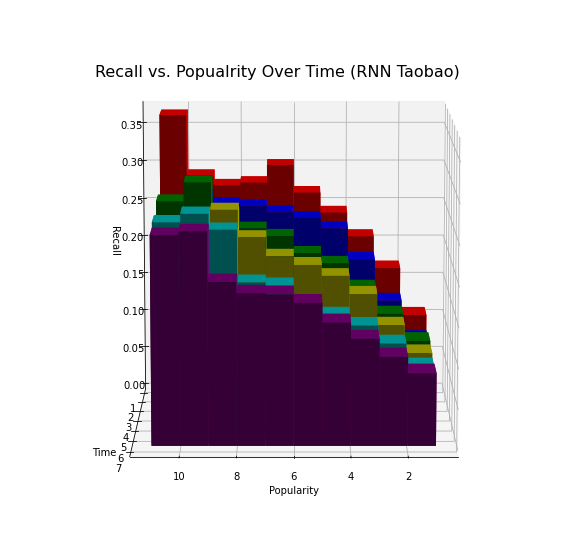

In [91]:
fig_recall = plt.figure(figsize=(10,10))
fig_recall.suptitle('Recall vs. Popualrity Over Time (RNN Taobao)', fontsize=16, y=.8)
ax = fig_recall.add_subplot(111, projection='3d')
x = [i for i in range(1, num_buckets + 1)]*num_times
repeat = [t for t in range(1,  num_times + 1)]
y = [element for element in repeat for i in range(num_buckets)]
z = 0
dx = 1
dy = 1
dz = np.array([time_bucket_recall_dict[time][k] for time in repeat for k in range(1, num_buckets+1)])
c = ['r','b','g','y','c', 'purple']
cs = [color for color in c for i in range(num_buckets)]
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=cs)
ax.view_init(elev=10, azim=90)
ax.set_xlabel('Popularity')
ax.set_ylabel('Time', labelpad=10)
ax.set_zlabel('Recall', labelpad=10)
plt.show()



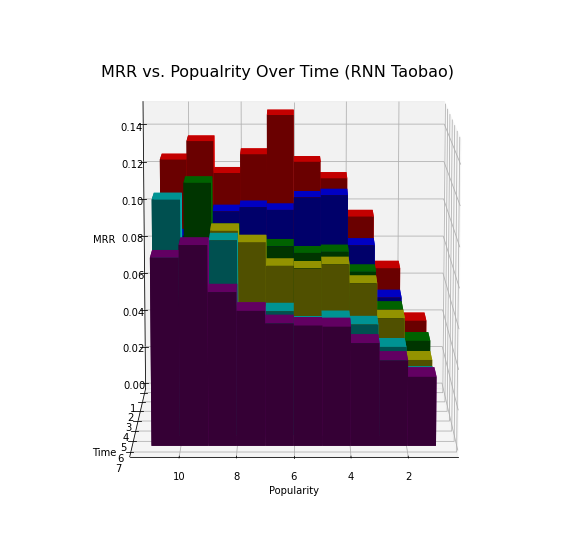

In [92]:
fig_mrr = plt.figure(figsize=(10,10))
fig_mrr.suptitle('MRR vs. Popualrity Over Time (RNN Taobao)', fontsize=16, y=.8)
ax = fig_mrr.add_subplot(111, projection='3d')
x = [i for i in range(1, num_buckets + 1)]*num_times
repeat = [t for t in range(1,  num_times + 1)]
y = [element for element in repeat for i in range(num_buckets)]
z = 0
dx = 1
dy = 1
dz = np.array([time_bucket_mrr_dict[time][k] for time in repeat for k in range(1, num_buckets+1)])
c = ['r','b','g','y','c', 'purple']
cs = [color for color in c for i in range(num_buckets)]
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=cs)
ax.view_init(elev=10, azim=90)
ax.set_xlabel('Popularity')
ax.set_ylabel('Time', labelpad=10)
ax.set_zlabel('MRR', labelpad=20)
plt.show()

In [93]:
pred_pop_dict = {}
for time in time_item_pred_dict.keys():
    for item in time_item_pred_dict[time]:
        if item in time_item_freq_dict[time]:
            pop = time_item_freq_dict[time][item]
            if pop not in pred_pop_dict:
                pred_pop_dict[pop] = []
            pred_pop_dict[pop].append(time_item_pred_dict[time][item])
            
for pop, num_pred in pred_pop_dict.items():
    pred_pop_dict[pop] = np.mean(num_pred)

ordered_pop_pred = collections.OrderedDict(sorted(pred_pop_dict.items()))
print(ordered_pop_pred)

OrderedDict([(1.0, 11.436222252209703), (2.0, 13.778550599416784), (3.0, 16.090452969529554), (4.0, 19.45116804822909), (5.0, 21.56793870341808), (6.0, 25.065073553028842), (7.0, 28.09866711375639), (8.0, 31.725378186819), (9.0, 36.02587011601547), (10.0, 39.41402676605116), (11.0, 44.52865840856603), (12.0, 50.97845048742945), (13.0, 56.101605929586164), (14.0, 60.38450654403962), (15.0, 62.72798165137615), (16.0, 70.69665167416292), (17.0, 77.8483556638246), (18.0, 76.74330042313117), (19.0, 88.5267924528302), (20.0, 92.92336802270577), (21.0, 92.81052631578947), (22.0, 100.8236074270557), (23.0, 111.43723554301833), (24.0, 116.2877358490566), (25.0, 123.125), (26.0, 142.06042884990254), (27.0, 134.05353319057815), (28.0, 159.4070796460177), (29.0, 162.25130890052355), (30.0, 140.71693121693121), (31.0, 159.25076452599387), (32.0, 168.38741721854305), (33.0, 197.55555555555554), (34.0, 184.9517543859649), (35.0, 219.5279187817259), (36.0, 189.55825242718447), (37.0, 156.6379310344827

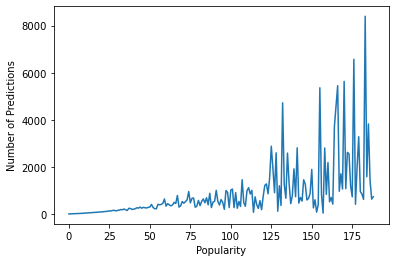

In [94]:
plt.plot(list(ordered_pop_pred.values()))
plt.ylabel('Number of Predictions')
plt.xlabel('Popularity')
plt.show()

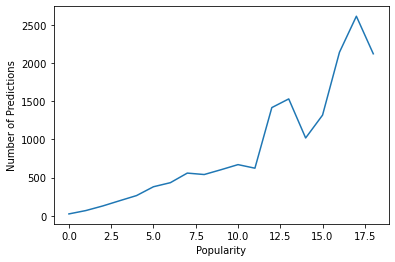

In [95]:
pop_pred_bucket_dict = {}
for num, num_pred in enumerate(ordered_pop_pred.values()):
    bucketid = num // 10
    if bucketid not in pop_pred_bucket_dict:
        pop_pred_bucket_dict[bucketid] = []
    pop_pred_bucket_dict[bucketid].append(num_pred)

for bucket, num_preds in pop_pred_bucket_dict.items():
    pop_pred_bucket_dict[bucket] = np.mean(num_preds)

plt.plot(list(pop_pred_bucket_dict.values()))
plt.ylabel('Number of Predictions')
plt.xlabel('Popularity')
plt.show()

In [96]:
recalls_pop_bucket = np.array([[time_bucket_recall_dict[time][k] for time in repeat] for k in range(1, num_buckets+1)])
mrrs_pop_bucket = np.array([[time_bucket_mrr_dict[time][k] for time in repeat] for k in range(1, num_buckets+1)])
print(recalls_pop_bucket)
print(mrrs_pop_bucket)

[[0.10790977 0.08763064 0.0959035  0.091464   0.08600079 0.08986346]
 [0.16981501 0.13713809 0.13065302 0.12699914 0.11505579 0.11003348]
 [0.2115116  0.19097097 0.16448808 0.1665134  0.13749819 0.13222288]
 [0.24269972 0.23072698 0.19536061 0.18931011 0.15038908 0.1522907 ]
 [0.26876236 0.24433475 0.20812258 0.20315273 0.16088082 0.17638724]
 [0.30450655 0.25160019 0.23023351 0.21397314 0.1873423  0.18678592]
 [0.28184929 0.2594964  0.23964416 0.23762805 0.1910152  0.1882117 ]
 [0.27838156 0.26237056 0.2586945  0.27230924 0.25627819 0.2019972 ]
 [0.29088865 0.2735659  0.29829174 0.254371   0.27598541 0.26358749]
 [0.36960784 0.25321271 0.27434471 0.25294412 0.26550147 0.25901961]]
[[0.0404345  0.03381426 0.03875139 0.03343374 0.03030093 0.03446553]
 [0.0683479  0.05695169 0.05504796 0.05482304 0.04468284 0.04261693]
 [0.09566042 0.08425622 0.07434281 0.07260495 0.05598383 0.05116904]
 [0.11576315 0.11027934 0.08461206 0.0821559  0.05868873 0.05933686]
 [0.12437633 0.10914877 0.0841010

[]

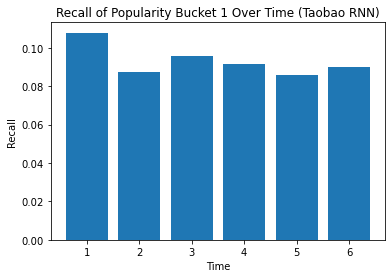

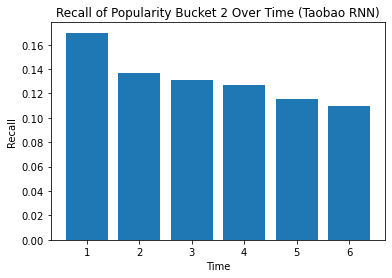

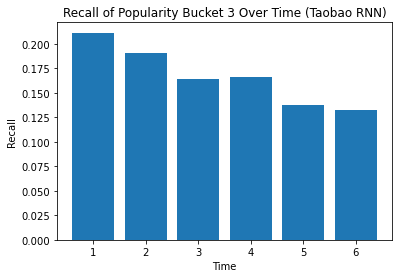

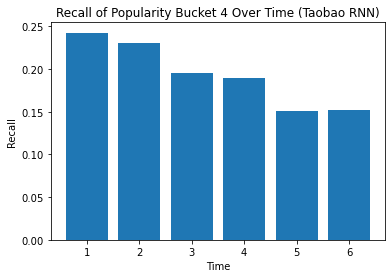

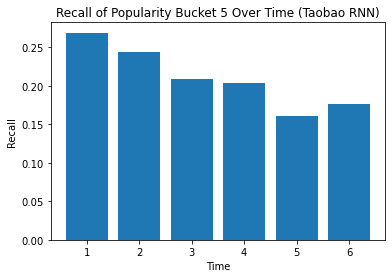

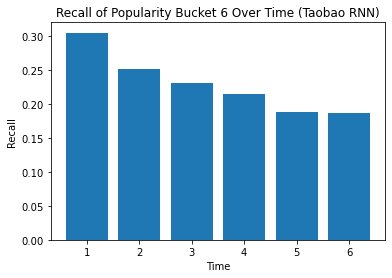

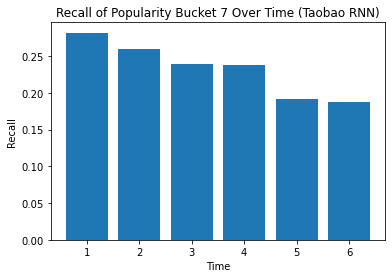

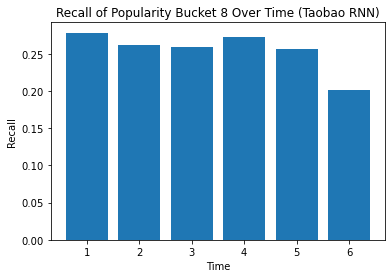

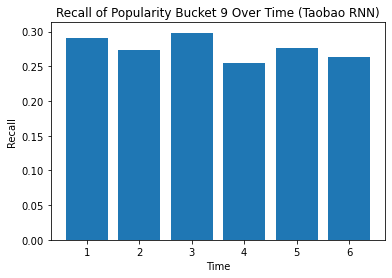

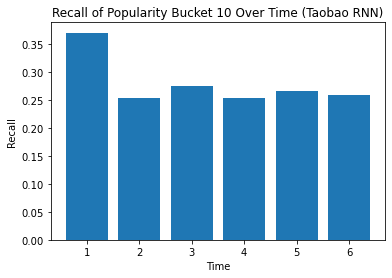

In [97]:
for bucket_num in range(num_buckets):
    plt.figure()
    plt.bar(np.arange(1, num_times+1), recalls_pop_bucket[bucket_num,:])
    plt.xlabel('Time')
    plt.ylabel('Recall')
    plt.title('Recall of Popularity Bucket %d Over Time (Taobao RNN)'%(bucket_num+1))
plt.plot()

[]

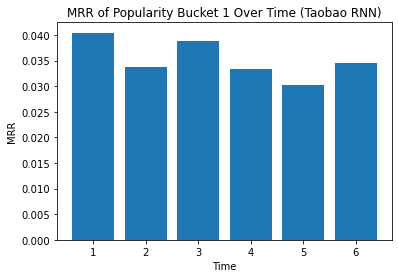

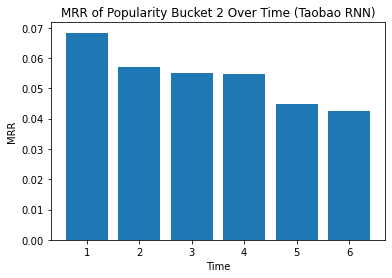

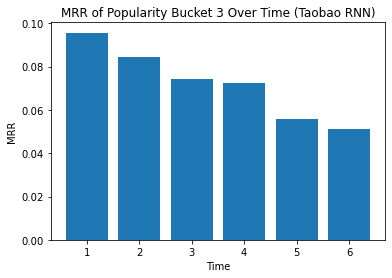

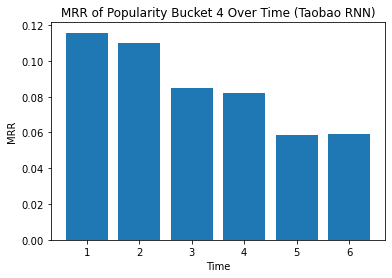

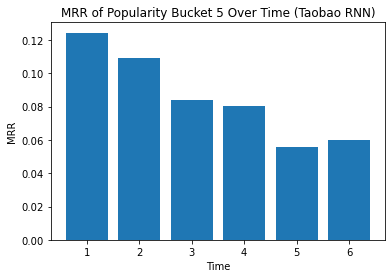

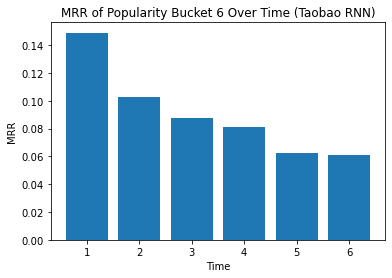

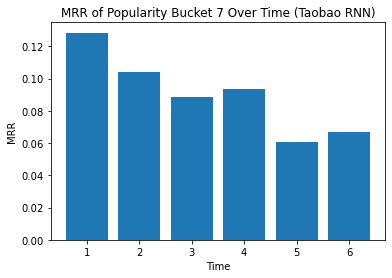

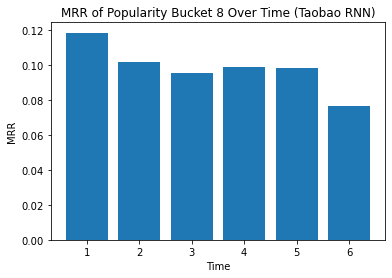

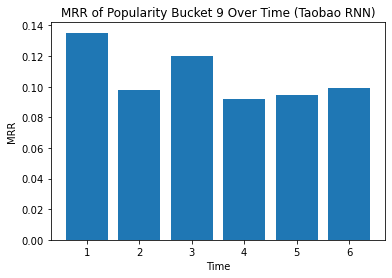

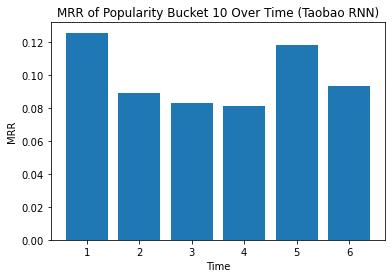

In [98]:
for bucket_num in range(num_buckets):
    plt.figure()
    plt.bar(np.arange(1, num_times+1), mrrs_pop_bucket[bucket_num,:])
    plt.xlabel('Time')
    plt.ylabel('MRR')
    plt.title('MRR of Popularity Bucket %d Over Time (Taobao RNN)'%(bucket_num+1))
plt.plot()